## Assignment 3: $k$ Nearest Neighbor

### Q1: Conceptual Questions

**1. What is the difference between regression and classification?**

Regression predicts a continuous numeric outcome (e.g., price in dollars), while classification predicts a categorical label (e.g., "mammal" vs. "bird"). We evaluate regression with metrics like MSE/SSE, and classification with metrics like accuracy and confusion matrices.

**2. What is a confusion table? What does it help us understand about a model's performance?**

A confusion table (or confusion matrix) cross-tabulates predicted class labels against actual class labels. Entries on the diagonal are correct predictions; off-diagonal entries are misclassifications. It helps us see not just overall accuracy, but *which* classes get confused with which, revealing specific model weaknesses.

**3. What does the SSE quantify about a particular model?**

SSE (Sum of Squared Errors) measures the total squared difference between predicted and actual values: $\text{SSE} = \sum(y_i - \hat{y}_i)^2$. It quantifies how far off the model's predictions are from the truth overall. Lower SSE means better fit.

**4. What are overfitting and underfitting?**

Overfitting occurs when a model learns noise in the training data rather than the true pattern, leading to great training performance but poor test performance. Underfitting occurs when a model is too simple to capture the underlying pattern, performing poorly on both training and test data. In $k$-NN, a very small $k$ (like 1) tends to overfit, while a very large $k$ tends to underfit.

**5. Why does splitting data into training/testing sets and choosing $k$ on the test set improve performance?**

If we evaluate on the same data we train on, we can't distinguish true learning from memorization. Holding out a test set gives an honest estimate of performance on unseen data. Choosing $k$ based on test-set performance finds the right bias-variance balance, producing a model that generalizes better.

**6. Strengths and weaknesses of predicting class labels vs. probability distributions.**

- *Class labels*: Simple and easy to interpret; useful when a definitive decision is needed. However, they hide uncertainty — a prediction of "class A" could reflect 99% or 51% confidence.
- *Probability distributions*: Show the model's confidence across all classes, allowing more nuanced decisions (e.g., flagging uncertain cases). They also let us adjust decision thresholds. The downside is added complexity, and $k$-NN probabilities (based on neighbor vote proportions) may not be well-calibrated.

---
### Q2: $k$-NN Regression — USA Cars

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

**Q2.1** Load data, keep relevant columns, check for NAs.

In [2]:
cars = pd.read_csv('./data/USA_cars_datasets.csv')
cars = cars[['price', 'year', 'mileage']]

print("Missing values:")
print(cars.isna().sum())
print(f"\nShape: {cars.shape}")
cars.head()

Missing values:
price      0
year       0
mileage    0
dtype: int64

Shape: (2499, 3)


,price,year,mileage
0,6300,2008,274117
1,2899,2011,190552
2,5350,2018,39590
3,25000,2014,64146
4,27700,2018,6654


**Q2.2** Max-min normalize `year` and `mileage`.

In [3]:
for col in ['year', 'mileage']:
    cars[col] = (cars[col] - cars[col].min()) / (cars[col].max() - cars[col].min())

cars.head()

,price,year,mileage
0,6300,0.744681,0.269287
1,2899,0.808511,0.187194
2,5350,0.957447,0.038892
3,25000,0.872340,0.063016
4,27700,0.957447,0.006537


**Q2.3** Split into ~80% training and ~20% testing.

In [4]:
X = cars[['year', 'mileage']]
y = cars['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training: {X_train.shape[0]} rows, Testing: {X_test.shape[0]} rows")

Training: 1999 rows, Testing: 500 rows


**Q2.4** Fit $k$-NN for $k=3,10,25,50,100,300$; compute MSE and plot predicted vs. actual.

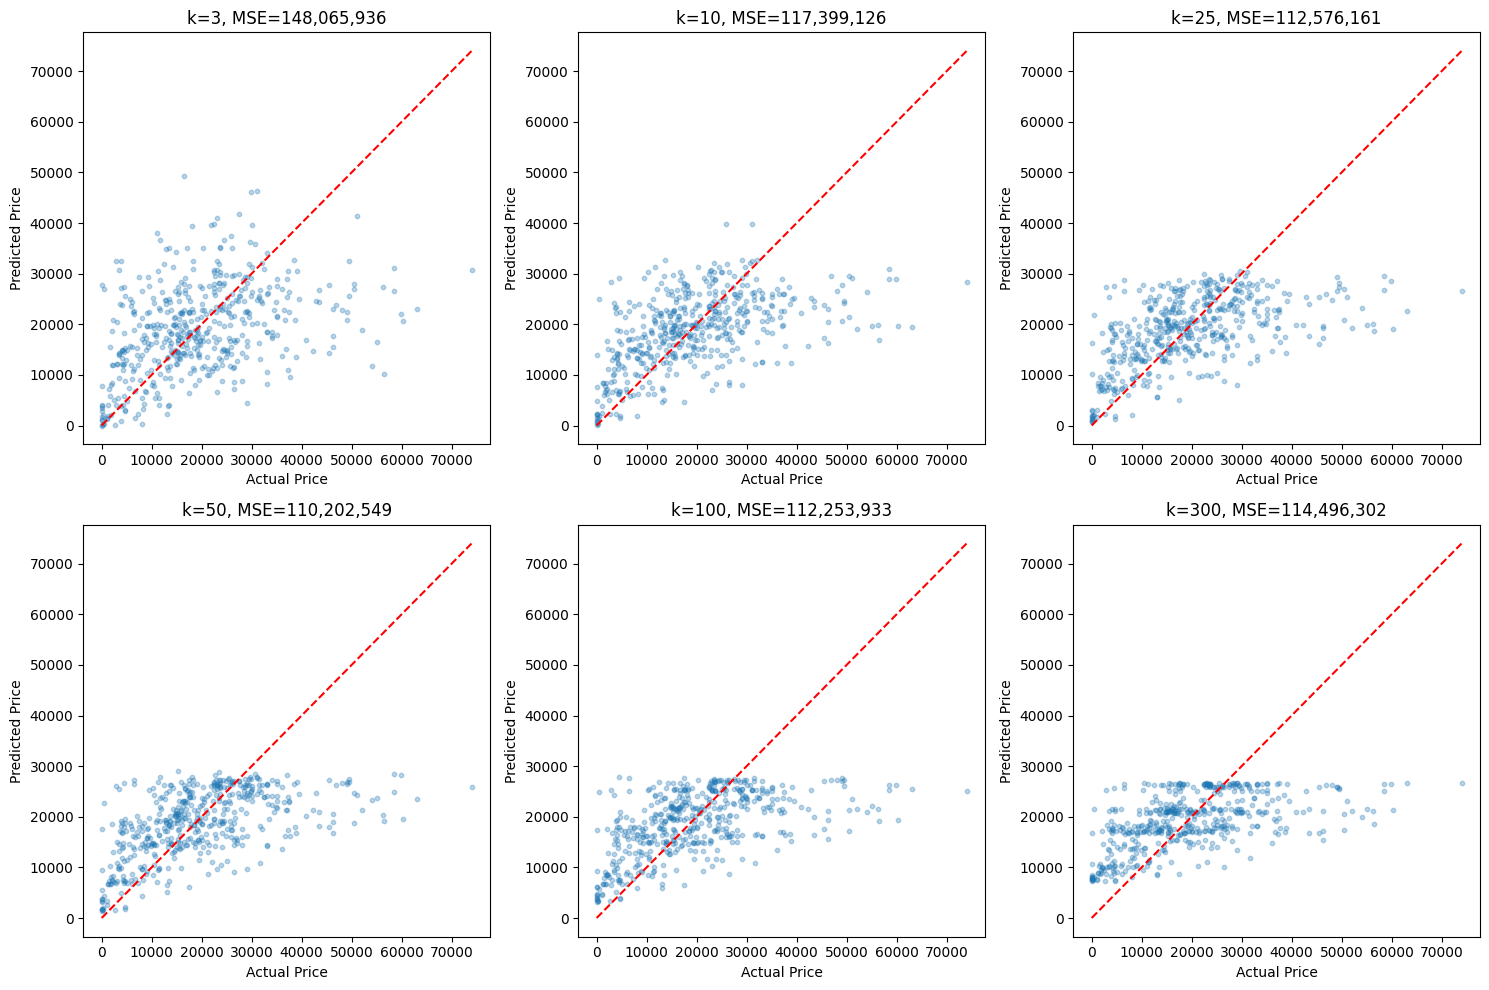

In [5]:
k_values = [3, 10, 25, 50, 100, 300]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, k in enumerate(k_values):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)
    mse = mean_squared_error(y_test, y_pred)
    
    axes[i].scatter(y_test, y_pred, alpha=0.3, s=10)
    mn = min(y_test.min(), y_pred.min())
    mx = max(y_test.max(), y_pred.max())
    axes[i].plot([mn, mx], [mn, mx], 'r--')
    axes[i].set_title(f'k={k}, MSE={mse:,.0f}')
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')

plt.tight_layout()
plt.show()

As $k$ increases, the predictions become less variable and cluster more tightly toward the mean price. With small $k$, predictions spread out and follow the actual values more closely (but with noise). With large $k$, the model averages over too many neighbors and predictions flatten, losing the ability to distinguish high- and low-priced cars.

**Q2.5** Determine the optimal $k$.

Optimal k: 49, MSE: 109,931,223


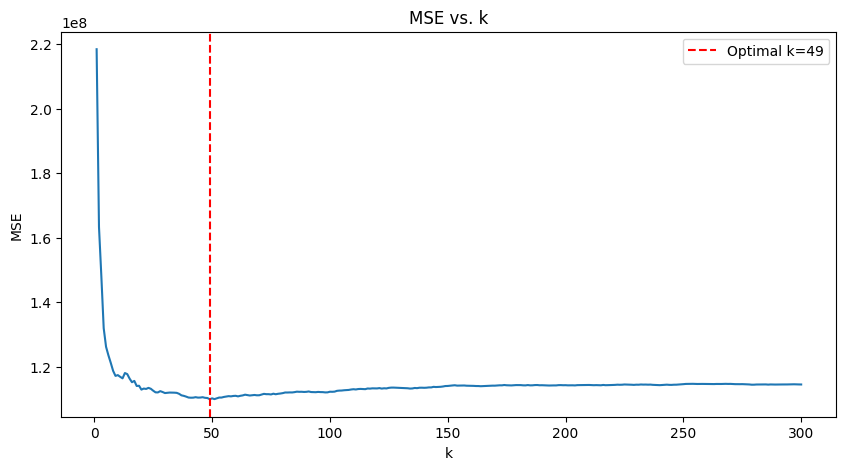

In [6]:
k_range = range(1, 301)
mse_list = []

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)
    mse_list.append(mean_squared_error(y_test, y_pred))

optimal_k = list(k_range)[np.argmin(mse_list)]
print(f"Optimal k: {optimal_k}, MSE: {min(mse_list):,.0f}")

plt.figure(figsize=(10, 5))
plt.plot(list(k_range), mse_list)
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs. k')
plt.legend()
plt.show()

**Q2.6** Interpretation of plots as $k$ varies.

At very small $k$ (e.g., $k=3$), the model **overfits**: predictions are highly variable and sensitive to noisy data points, even though they roughly track the diagonal. As $k$ increases to the optimal value, the model strikes the right balance between bias and variance, and the scatter around the diagonal tightens. At very large $k$ (e.g., $k=300$), the model **underfits**: it averages over too many neighbors and predictions collapse toward the overall mean, producing a horizontal band rather than tracking the diagonal. The MSE vs. $k$ curve confirms this U-shaped pattern—error is high at both extremes and minimized at the optimal $k$.

---
### Q3: $k$-NN Classification — Animals (Zoo Data)

**Q3.1** Load data and EDA.

In [7]:
animals = pd.read_csv('./data/zoo.csv')
print("Shape:", animals.shape)
animals.head()

Shape: (101, 18)


,animal,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [8]:
# Print animals in each class
for c in sorted(animals['class'].unique()):
    members = animals.loc[animals['class'] == c, 'animal'].values
    print(f"Class {c} ({len(members)} members): {', '.join(members)}\n")

Class 1 (41 members): aardvark, antelope, bear, boar, buffalo, calf, cavy, cheetah, deer, dolphin, elephant, fruitbat, giraffe, girl, goat, gorilla, hamster, hare, leopard, lion, lynx, mink, mole, mongoose, opossum, oryx, platypus, polecat, pony, porpoise, puma, pussycat, raccoon, reindeer, seal, sealion, squirrel, vampire, vole, wallaby, wolf

Class 2 (20 members): chicken, crow, dove, duck, flamingo, gull, hawk, kiwi, lark, ostrich, parakeet, penguin, pheasant, rhea, skimmer, skua, sparrow, swan, vulture, wren

Class 3 (5 members): pitviper, seasnake, slowworm, tortoise, tuatara

Class 4 (13 members): bass, carp, catfish, chub, dogfish, haddock, herring, pike, piranha, seahorse, sole, stingray, tuna

Class 5 (4 members): frog, frog, newt, toad

Class 6 (8 members): flea, gnat, honeybee, housefly, ladybird, moth, termite, wasp

Class 7 (10 members): clam, crab, crayfish, lobster, octopus, scorpion, seawasp, slug, starfish, worm



In [9]:
# Class sizes
print("Class sizes:")
print(animals['class'].value_counts().sort_index())

# Feature variation
feature_cols = [c for c in animals.columns if c not in ['animal', 'class']]
print("\nFeature standard deviations:")
print(animals[feature_cols].std().sort_values(ascending=False).round(3))

Class sizes:
class
1    41
2    20
3     5
4    13
5     4
6     8
7    10
Name: count, dtype: int64

Feature standard deviations:
legs        2.033
predator    0.500
catsize     0.498
hair        0.497
eggs        0.495
milk        0.494
toothed     0.492
aquatic     0.481
tail        0.439
airborne    0.428
breathes    0.408
feathers    0.400
backbone    0.385
fins        0.376
domestic    0.337
venomous    0.271
dtype: float64


Class 1 (mammals) is the largest group. Some classes are very small (e.g., classes 3 and 7 may have only a handful of members). Features like `legs` have the most variation, while binary features like `milk`, `feathers`, `eggs`, `backbone`, and `airborne` are likely strong predictors since they cleanly separate biological groups (e.g., `milk` identifies mammals, `feathers` identifies birds).

**Q3.2** Split 50/50 into training and testing sets.

In [10]:
feature_cols = [c for c in animals.columns if c not in ['animal', 'class']]
X = animals[feature_cols]
y = animals['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print(f"Training: {X_train.shape[0]}, Testing: {X_test.shape[0]}")

Training: 50, Testing: 51


**Q3.3** Build a $k$-NN classifier using all variables; select $k$.

Optimal k: 1, Accuracy: 0.961


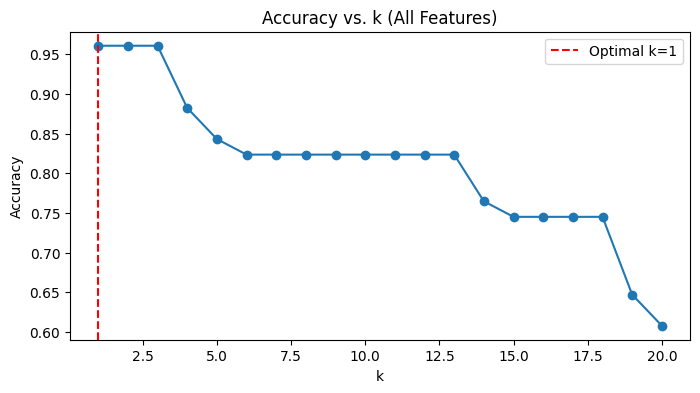

In [11]:
# Test k from 1 to 20 (dataset is small, so k shouldn't be too large)
k_range = range(1, 21)
acc_list = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)
    acc_list.append(accuracy_score(y_test, y_pred))

optimal_k = list(k_range)[np.argmax(acc_list)]
print(f"Optimal k: {optimal_k}, Accuracy: {max(acc_list):.3f}")

plt.figure(figsize=(8, 4))
plt.plot(list(k_range), acc_list, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k (All Features)')
plt.legend()
plt.show()

I selected $k$ by testing values from 1 to 20 and choosing the $k$ that maximizes test-set accuracy. The dataset is small (~100 observations), so we don't need very large $k$. The accuracy plot shows which $k$ performs best.

**Q3.4** Confusion table for the optimal model.

Accuracy: 0.961



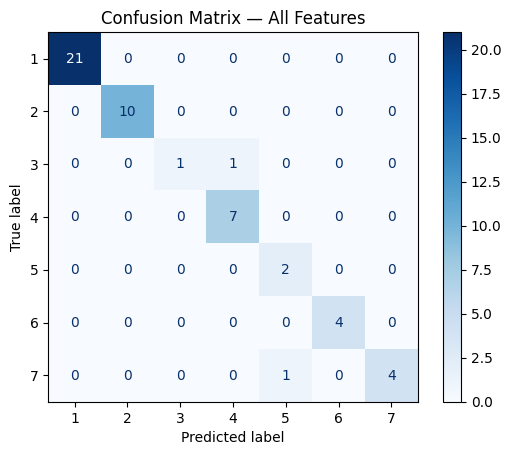

In [12]:
model = KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix — All Features')
plt.show()

The model achieves high accuracy with all 16 features. Any misclassifications likely occur between classes that share many characteristics — for example, reptiles and amphibians are biologically similar, so the model may occasionally confuse them. Classes with very few members are also harder to classify correctly due to limited training examples.

**Q3.5** Use only `milk`, `aquatic`, and `airborne` as features.

Best k (reduced): 2, Accuracy: 0.725

Accuracy: 0.725
Predicted classes: [np.int64(1), np.int64(2), np.int64(4)]
Actual classes:    [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]



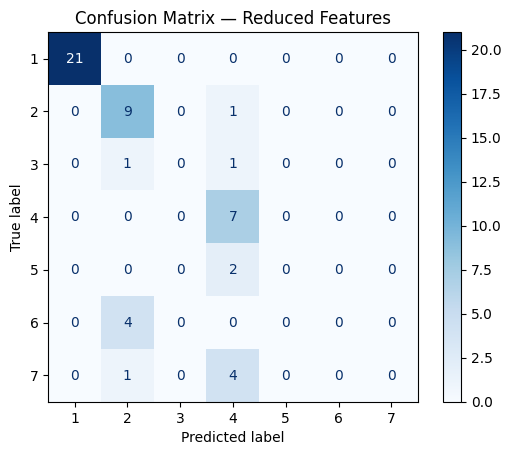

In [13]:
reduced_features = ['milk', 'aquatic', 'airborne']
X_train_r = X_train[reduced_features]
X_test_r = X_test[reduced_features]

# Find best k for reduced model
acc_list_r = []
for k in range(1, 21):
    m = KNeighborsClassifier(n_neighbors=k)
    m.fit(X_train_r.values, y_train.values)
    acc_list_r.append(accuracy_score(y_test, m.predict(X_test_r.values)))

best_k_r = list(range(1, 21))[np.argmax(acc_list_r)]
print(f"Best k (reduced): {best_k_r}, Accuracy: {max(acc_list_r):.3f}")

model_r = KNeighborsClassifier(n_neighbors=best_k_r)
model_r.fit(X_train_r.values, y_train.values)
y_pred_r = model_r.predict(X_test_r.values)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_r):.3f}")
print(f"Predicted classes: {sorted(np.unique(y_pred_r))}")
print(f"Actual classes:    {sorted(y_test.unique())}\n")

cm_r = confusion_matrix(y_test, y_pred_r)
disp_r = ConfusionMatrixDisplay(cm_r, display_labels=sorted(y.unique()))
disp_r.plot(cmap='Blues')
plt.title('Confusion Matrix — Reduced Features')
plt.show()

In [14]:
# Predicted probabilities
probs = model_r.predict_proba(X_test_r.values)
prob_df = pd.DataFrame(probs, columns=model_r.classes_)
print("Classes in model:", list(model_r.classes_))
print("\nPredicted probabilities (first 10 rows):")
prob_df.head(10)

Classes in model: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Predicted probabilities (first 10 rows):


,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.5,0.0,0.0,0.5
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.5,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0


With only three binary features (`milk`, `aquatic`, `airborne`), there are only $2^3 = 8$ possible feature combinations, which is not enough to distinguish all seven classes. The model can only predict the subset of classes that dominate each feature combination. For example, `milk=1` strongly maps to class 1 (mammals), and `airborne=1` maps to class 2 (birds). But classes that share the same values on all three features (like reptiles, amphibians, and insects, which are all non-milk, non-airborne, non-aquatic) become indistinguishable.

The probability output from `predict_proba` confirms this: some classes may not appear in the model's class list at all if no training neighbors belong to those classes, or the probabilities for certain classes may be zero. The reduced feature set simply doesn't contain enough information to separate all seven groups.

---
### Q4: Custom Kernel Density Plot Function

In [15]:
import seaborn as sns
from scipy.spatial.distance import cdist

In [16]:
def my_kdeplot(data, kernel='gaussian', bw=None, n_points=500, ax=None, label=None):
    """
    Custom kernel density estimate plot.
    
    Parameters:
        data: Pandas Series or NumPy array of observations
        kernel: 'gaussian', 'uniform', or 'epanechnikov'
        bw: bandwidth (float). Default uses Silverman's rule: 0.9 * min(std, IQR/1.34) * n^(-1/5)
        n_points: number of points on the x-axis grid
        ax: matplotlib Axes to plot on (creates one if None)
        label: label for the line
    """
    data = np.asarray(data, dtype=float)
    data = data[~np.isnan(data)]  # drop NaNs
    n = len(data)
    
    # Silverman plug-in bandwidth
    if bw is None:
        std = np.std(data, ddof=1)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bw = 0.9 * min(std, iqr / 1.34) * n ** (-1/5)
        if bw <= 0:  # guard against zero bandwidth
            bw = 1.0
    
    # Kernel functions
    def gaussian_kernel(z):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-z**2 / 2)
    
    def uniform_kernel(z):
        return np.where(np.abs(z) <= 1, 0.5, 0.0)
    
    def epanechnikov_kernel(z):
        return np.where(np.abs(z) <= 1, 0.75 * (1 - z**2), 0.0)
    
    kernels = {
        'gaussian': gaussian_kernel,
        'uniform': uniform_kernel,
        'epanechnikov': epanechnikov_kernel
    }
    
    if kernel not in kernels:
        raise ValueError(f"Unknown kernel '{kernel}'. Choose from: {list(kernels.keys())}")
    
    k_func = kernels[kernel]
    
    # Evaluation grid — extend beyond data range for nice tails
    pad = 3 * bw
    x_grid = np.linspace(data.min() - pad, data.max() + pad, n_points)
    
    # Use cdist for efficient vectorized distance computation (no for loops)
    dists = cdist(x_grid.reshape(-1, 1), data.reshape(-1, 1), metric='euclidean')
    z = dists / bw  # standardize by bandwidth
    
    # KDE formula: f(x) = (1 / n*h) * sum of K((x - xi) / h)
    density = k_func(z).sum(axis=1) / (n * bw)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x_grid, density, label=label)
    ax.set_ylabel('Density')
    
    return ax

**Demo:** Compare custom KDE with Seaborn's `kdeplot` using the car price data.

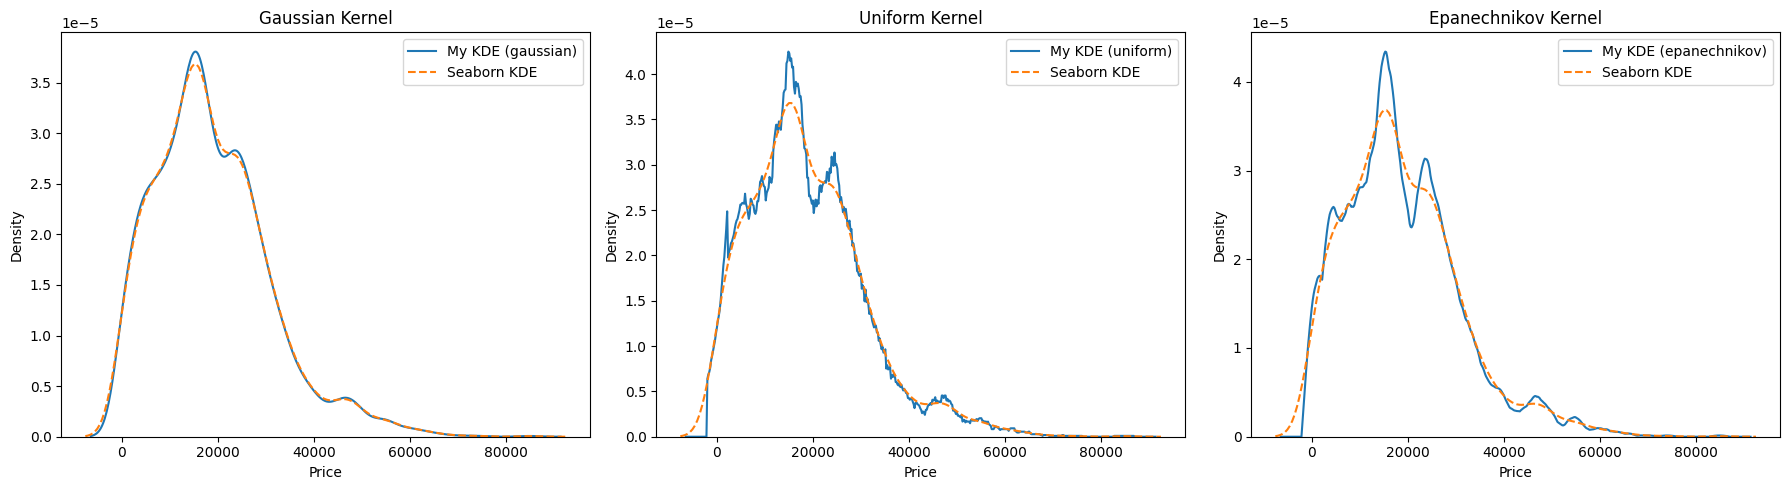

In [17]:
# Use car prices as demo data
demo_data = pd.read_csv('./data/USA_cars_datasets.csv')['price']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, kern in enumerate(['gaussian', 'uniform', 'epanechnikov']):
    my_kdeplot(demo_data, kernel=kern, ax=axes[i], label=f'My KDE ({kern})')
    sns.kdeplot(demo_data, ax=axes[i], label='Seaborn KDE', linestyle='--')
    axes[i].set_title(f'{kern.capitalize()} Kernel')
    axes[i].legend()
    axes[i].set_xlabel('Price')

plt.tight_layout()
plt.show()

The custom function produces density curves that closely match Seaborn's `kdeplot` for the Gaussian kernel (small differences arise from bandwidth selection methods). The uniform kernel produces a blockier estimate, and the Epanechnikov kernel is a smooth compromise between the two. All three use Silverman's plug-in bandwidth by default and leverage `cdist` for efficient vectorized distance computation rather than slow `for` loops.